# Практическая работа № 10-11
# Оценка погрешности вычисления координат объекта по азимуту от визиров с двух навигационных маяков


На ближайших двух занятиях будем заниматься моделированием погрешностей в задаче локальной навигации.

Контекст следующий:

объект перемещается в зоне прямой видимости двух специальных устройств - оптических навигационных маяков; координаты маяков известны; известны азимуты визирования с маяков на объект.

Задача:

- вычислить координаты объекта;
- оценить влияние шума в исходных данных на погрешность оценки координат объекта.


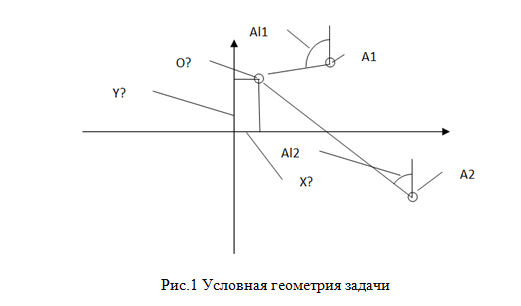

Пусть X,Y -координаты объекта

[X1,Y1] – координаты первого маяка

[X2,Y2] – координаты второго маяка

Al1- азимут визирования с первого маяка на определяемый объект

Al2- азимут визирования с второго маяка на определяемый объект






## Практическая работа №10

### 1. Вычисление координат по азимутам визирования

Координаты объекта находятся из простой системы уравнений:

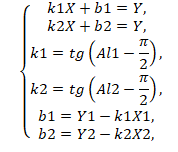

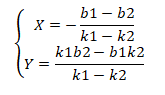

---------------
**Самостоятельно**: попробуйте вывести эти формулы, исходя из геометрии задачи


Вычислим координаты для тестового набора данных

- X1,Y1 = 3,4 #Координаты первого анкера
- X2,Y2 = 5,-2 #Координаты второго анкера
- Al_1 = 130 #азимут визирования с первого анкера на определяемый объект, градусы
- Al_2 = 50 #азимут визирования с второго анкера на определяемый объект, градусы

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
X1,Y1 = 3,4 #Координаты первого визора
X2,Y2 = 5,-2 #Координаты второго визора
Al_1 = 130 #азимут визирования с первого визора на определяемый объект, градусы
Al_2 = 50 #азимут визирования с второго визора на определяемый объект, градусы

In [3]:
Az = np.array([Al_1 * np.pi / 180, Al_2 * np.pi / 180]) #радианы
Az

array([2.26892803, 0.87266463])

In [4]:
X_v = np.array([X1, X2])
Y_v = np.array([Y1, Y2])

In [5]:
k = np.tan(Az - np.pi/2)
k

array([ 0.83909963, -0.83909963])

In [6]:
b = Y_v - k*X_v
b

array([1.48270111, 2.19549816])

In [7]:
X = -(b[0] - b[1]) / (k[0] - k[1])
X

0.42473922221737

In [8]:
Y = k[0] * X + b[0]
Y

1.8390996311772796

In [9]:
Y_test = k[1] * X + b[1]
Y_test

1.8390996311772796

Визуализируем решение

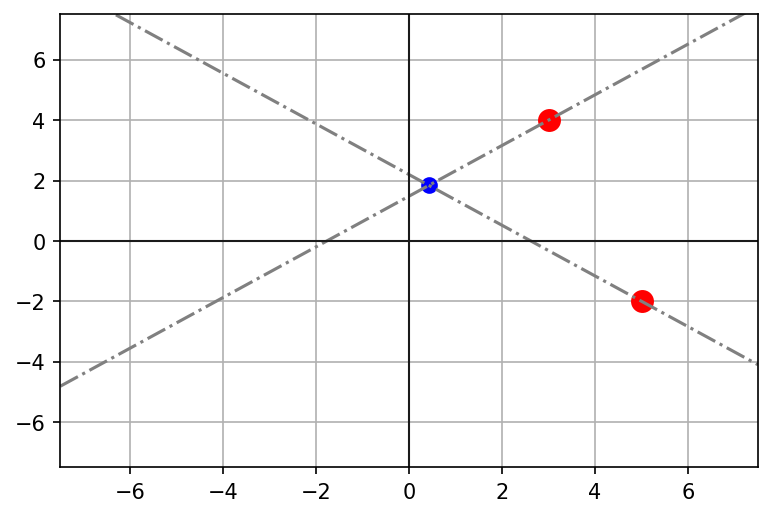

In [10]:
plt.figure(dpi=150)
plt.plot(X1,Y1, 'ro', markersize = 10)
plt.plot(X2,Y2, 'ro', markersize = 10)
plt.plot(X,Y, 'bo', markersize = 7)
plt.grid(True)


max_x = 1.5 * np.max(np.abs(np.array([X,X1,X2])))
max_y = 1.5 * np.max(np.abs(np.array([Y,Y1,Y2])))

x_grid = np.array([-max_x,max_x])
y_grid = np.array([-max_x,max_x])

line_v_1 = k[0] * x_grid + b[0]
line_v_2 = k[1] * x_grid + b[1]

plt.plot(np.array([-max_x,max_x]), line_v_1, '-.', color = '0.5')
plt.plot(np.array([-max_x,max_x]), line_v_2, '-.', color = '0.5')

plt.plot([0,0], y_grid, linewidth = 1, color = '0.1')
plt.plot(x_grid, [0,0], linewidth = 1, color = '0.1')

plt.xlim(x_grid)
plt.ylim(y_grid)

plt.style.use('seaborn-deep')

---------
**Самостоятельно:** экспериментируя с исходными данными, понаблюдайте, как меняется рисунок. Подумайте, что будет, если объект окажется ровно между маяками

### 2. Модель шума

Теперь рассмотрим, как сказывается наличие ошибки в азимутах визирования на погрешности расчета координат объекта в зависимости от его положения на плоскости. Для этого добавим в исходные данные случайную составляющую, имеющую нормальное распределение с нулевым математическим ожиданием и среднеквадратическим отклонением σ_n. 

Смоделируем его отдельно

In [11]:
std_az = 1
Mo = 0
N = std_az * np.random.randn(10000,1) + Mo

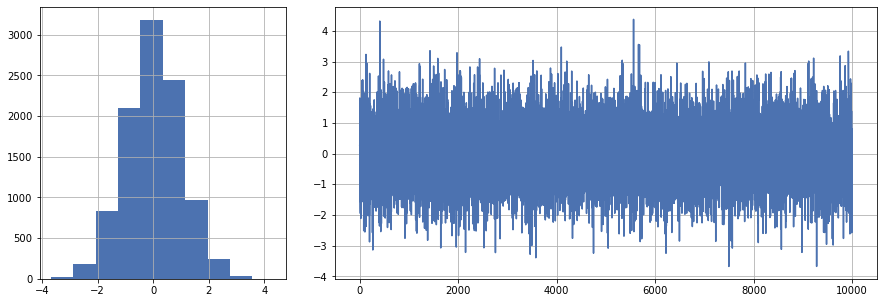

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.hist(N)
plt.grid(True)
plt.subplot(1,3,(2,3))
plt.plot(N)
plt.grid(True)
plt.style.use('seaborn-deep')

----------
**Самостоятельно** Поэкспериментируйте с параметрами шума, выясните их влияние.

В случае наличия шума в исходных данных речь уже идет не о значениях параметров, а об *оценках* этих значений, которые в случае аддитивного шума примут вид:

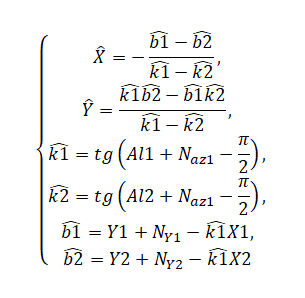


В качестве меры ошибки оценки координат будем использовать СКО в каждой точке для статистически значимого числа итераций K:

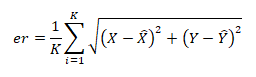

### 3. Подготовим данные

Как вы понимаете, для получения сколько-нибудь значимых результатов, в каждой точке нам необходимо сделать значительное число опытов. Прежде чем приступать к моделированию, давайте перепишем вычисление координат как отдельную функцию. Кроме того, т.к. нам предется рассчитывать координаты для сетки углов, хорошо бы, чтобы она могла принимать на вход не по одному угловому значению, а сразу все, и возвращала бы массивы координат. 

In [13]:
def compute_position(X1,Y1,Al_1,X2,Y2,Al_2):
    
    calc_k = lambda x: np.tan(x - np.pi / 2)
    calc_b = lambda x,y,k: y - k * x
    
    Az_1 = Al_1 * np.pi / 180
    Az_2 = Al_2 * np.pi / 180
    
    k1 = calc_k(Az_1)
    k2 = calc_k(Az_2)
    
    b1 = calc_b(X1, Y1, k1)
    b2 = calc_b(X2, Y2, k2)
    
    B1,B2 = np.meshgrid(b1,b2);
    K1,K2 = np.meshgrid(k1,k2);
    
    X = -(B1-B2) / (K1-K2)
    Y = K1 * X + B1    
    
    return X,Y

----------
**Самостоятельно** Разберитесь, что делает функция meshgrid; выясните, какую размерность имеют наборы координат на выходе функции

Проверим ее

In [14]:
X,Y = compute_position(X1,Y1,Al_1,X2,Y2,Al_2)
print(X,Y)

[[0.42473922]] [[1.83909963]]


Зададимся расположением маяков на оси Ox симметрично относительно нуля. Т.е. мы ожидаем наблюдать симметричную картину как относительно оси Ox, так и относительно Oy. 

In [15]:
X1,Y1,Al_1 = -50,0,300
X2,Y2,Al_2 = 50,0,50
X,Y = compute_position(X1,Y1,Al_1,X2,Y2,Al_2)
print(X,Y)

[[9.23962655]] [[34.20201433]]


In [16]:
Al_1 = np.arange(271,359,0.5)
Al_2 = np.arange(0,89,0.5)

Если рассчитать координаты объекта по данной сетки углов, с учетом симметрии, мы получим примерно следующую картину:

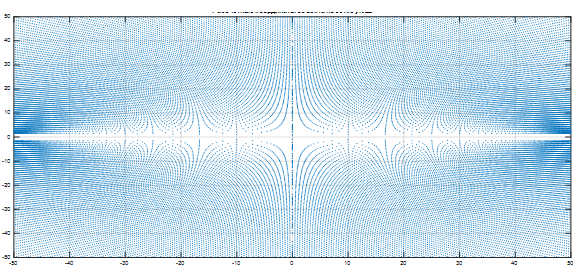

In [17]:
X,Y = compute_position(X1,Y1,Al_1,X2,Y2,Al_2)

In [18]:
X.shape

(178, 176)

In [19]:
Y.shape

(178, 176)

# Практическая работа № 11


На прошлом занятии мы разобрались с процедурой вычисления координат по азимутальным углам, выбрали модель шума. Теперь давайте рассчитаем координатные сетки для объекта и построим график, аналогичный показанному выше.

In [20]:
X1,Y1 = -50, 0
X2,Y2  = 50, 0
Al_1 = np.arange(271,359,1)
Al_2 = np.arange(0,89,1)

In [21]:
X,Y = compute_position(X1,Y1,Al_1,X2,Y2,Al_2)

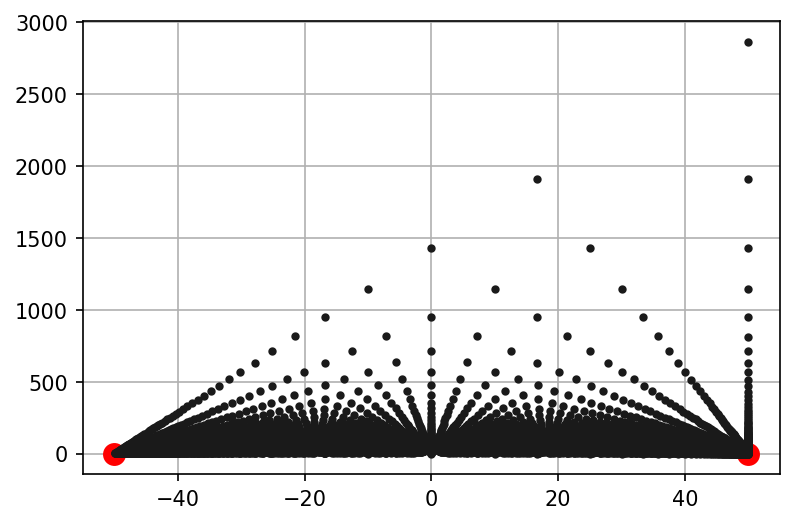

In [22]:
fig, ax = plt.subplots(1, dpi=150)
ax.plot(X1,Y1, 'ro', markersize = 10)
ax.plot(X2,Y2, 'ro', markersize = 10)
ax.grid(True)
for i in range(X.shape[0]):
    ax.plot(X[i,:], Y[i,:],'.', color = '0.1')

(0.0, 50.0)

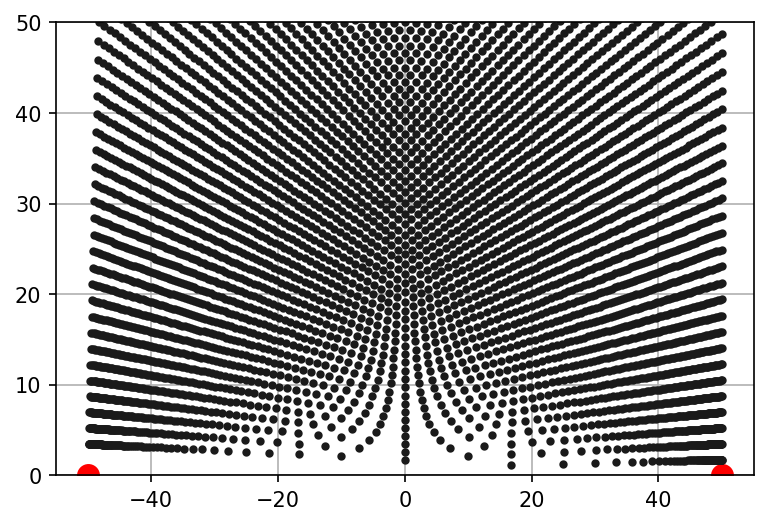

In [23]:
# Ограничим область видимости
fig, ax = plt.subplots(1, dpi=150)
ax.plot(X1,Y1, 'ro', markersize = 10)
ax.plot(X2,Y2, 'ro', markersize = 10)
ax.grid(True)
for i in range(X.shape[0]):
    ax.plot(X[i,:], Y[i,:],'.', color = '0.1')
    
ax.set_ylim(0,50)

При равномерной сетке по углам мы, очевидно, получаем неравноменую сетку для координат объекта. Причем наиболее интересная область вблизи оси x просчитывается наименее редко. Давайте используем неравномерную сетку по углам.

In [24]:
Al_1_1 = np.arange(271,275,0.25)
Al_1_2 = np.arange(275,359,1)

Al_1 = np.concatenate([Al_1_1, Al_1_2])

Al_2_1 = np.arange(0,85,1)
Al_2_2 = np.arange(85,89,0.25)
Al_2 = np.concatenate([Al_2_1, Al_2_2])

In [25]:
X,Y = compute_position(X1,Y1,Al_1,X2,Y2,Al_2)

(0.0, 50.0)

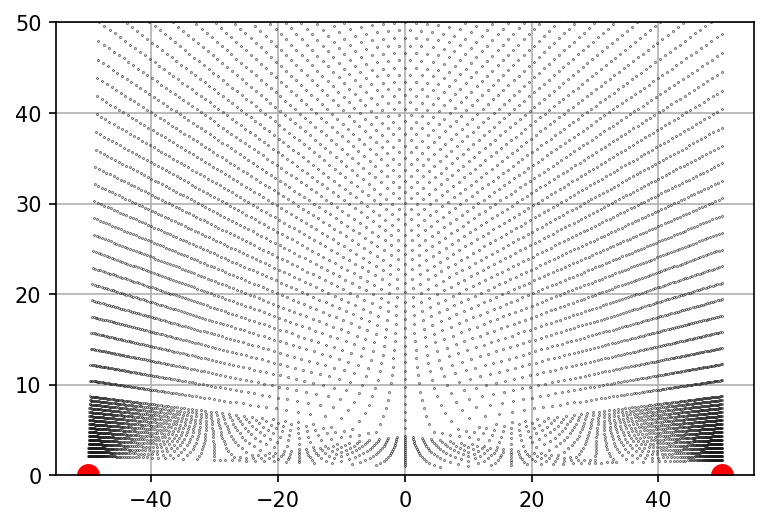

In [26]:
fig, ax = plt.subplots(1, dpi=150)
ax.plot(X1,Y1, 'ro', markersize = 10)
ax.plot(X2,Y2, 'ro', markersize = 10)
ax.grid(True)

for i in range(X.shape[0]):
    ax.plot(X[i,:], Y[i,:],'.', color = '0.1', markersize = 0.5)
    
ax.set_ylim(0,50)

### 4. Моделирование

In [27]:
K = 100
std_az = 1

err = np.zeros(X.shape)
err

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
for i in range(K):
    
    calc_err = lambda x, x_n, y, y_n: np.sqrt((x - x_n)**2 + (y - y_n)**2)
    
    Az1_n = Al_1 + std_az * np.random.randn(Al_1.shape[0])
    Az2_n = Al_2 + std_az * np.random.randn(Al_2.shape[0])
    
    X_n, Y_n = compute_position(X1,Y1,Az1_n,X2,Y2,Az2_n)
    
    err += calc_err(X,X_n,Y,Y_n)
err = err / K    

In [29]:
Al_1.shape

(100,)

In [30]:
N = np.random.randn(Al_1.shape[0])
N.shape

(100,)

In [31]:
err

array([[1.46383185e+00, 1.40024600e+00, 1.44769202e+00, ...,
        5.90079889e+02, 1.89184821e+03, 3.31409451e+03],
       [1.46299928e+00, 1.39950842e+00, 1.44725485e+00, ...,
        1.37357423e+03, 5.62154146e+02, 1.25996142e+03],
       [1.46198150e+00, 1.39825831e+00, 1.44500097e+00, ...,
        1.86425991e+02, 2.68348064e+02, 1.30953636e+03],
       ...,
       [3.06651803e+01, 3.03383862e+01, 2.76179007e+01, ...,
        1.38477647e+00, 1.38491594e+00, 1.38560061e+00],
       [6.48427696e+01, 2.88419092e+01, 2.19858784e+01, ...,
        1.32214192e+00, 1.32236731e+00, 1.32156108e+00],
       [3.62079410e+01, 4.60410556e+01, 3.22577472e+02, ...,
        1.50281607e+00, 1.50205303e+00, 1.50206975e+00]])

In [32]:
err.shape

(101, 100)

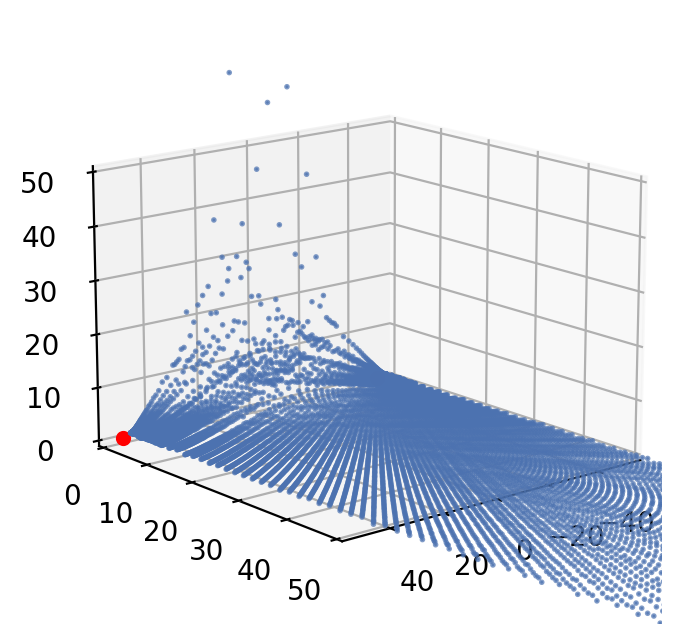

In [33]:
plt.figure(dpi = 200)
ax = plt.axes(projection = '3d')
ax.scatter(X,Y, err, alpha = 0.7, s = 1)
ax.scatter(X1,Y1,0,'ro', color = 'red')
ax.scatter(X2,Y2,0,'ro', color = 'red')
ax.set_ylim(0,50)
ax.set_zlim(0,50)
ax.view_init(15,50)

Представляют интерес границы области, в которой погрешности сохраняют адекватные значения, поэтому давайте построим сечение поверхности ошибок

Рассмотрим случай, когда объект перемещается строго вдоль оси Oy, и рассчитаем погрешности для различных значений σ_az. 
В этом случае азимуты визирования с первого и второго маяка связаны следующим соотношением: Al1 = 360 – Al2.


In [34]:
Al_2_1 = np.arange(20,85,1)
Al_2_2 = np.arange(85,89,0.25)
Al_2 = np.concatenate([Al_2_1, Al_2_2])

Al_1 = 360 - Al_2

Немного изменим функцию для расчета координат объекта, чтобы она возвращала одномерные векторы, а не матрицы

In [35]:
def compute_section(X1,Y1,Al_1,X2,Y2,Al_2):
    
    calc_k = lambda x: np.tan(x - np.pi / 2)
    calc_b = lambda x,y,k: y - k * x
    
    Az_1 = Al_1 * np.pi / 180
    Az_2 = Al_2 * np.pi / 180
    
    k1 = calc_k(Az_1)
    k2 = calc_k(Az_2)
    
    b1 = calc_b(X1, Y1, k1)
    b2 = calc_b(X2, Y2, k2)
    
    X = -(b1-b2) / (k1-k2)
    Y = k1 * X + b1    
    
    return X,Y

In [36]:
X,Y = compute_section(X1,Y1,Al_1,X2,Y2,Al_2)

In [37]:
X

array([-2.58616406e-14,  2.72751802e-14,  5.74155800e-15,  6.93697243e-14,
       -6.32708016e-15,  3.64464671e-14, -3.81210333e-14,  1.08611882e-14,
       -7.55604548e-15, -1.96930135e-14,  2.87162428e-14,  4.26937148e-15,
        5.77195292e-14, -9.22863696e-15,  1.91706851e-14,  1.49258214e-14,
        5.16239515e-15, -5.35432356e-15,  3.60838937e-14,  2.58923773e-14,
        1.49054037e-14,  3.08832688e-15, -9.59663329e-15, -1.32518364e-14,
        2.05848943e-14,  3.55271368e-15,  4.41473125e-14,  2.66687329e-14,
        1.97284414e-14,  8.17385915e-15, -0.00000000e+00, -4.38723602e-15,
       -2.27363307e-14,  1.41438309e-14,  4.88989088e-15, -5.07380096e-15,
        3.16026878e-14,  2.73534966e-14,  8.52829556e-15,  5.91270848e-15,
       -6.15348060e-15,  3.20463257e-14,  2.00450479e-14,  6.97259319e-15,
       -3.64207125e-15, -1.90470477e-14, -3.59078651e-14,  2.51090068e-14,
       -8.79327492e-15,  6.01583811e-14,  4.39245027e-14,  3.09534891e-14,
        1.09341284e-14, -

In [38]:
X == 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

Мы можем наблюдать, что X нигде не равен 0 в точности, однако очень к нему близок.

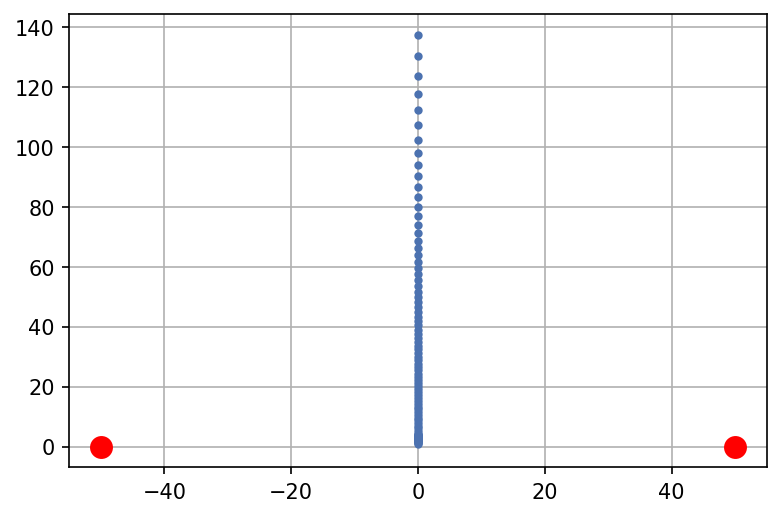

In [39]:
fig, ax = plt.subplots(1, dpi=150)
ax.plot(X1,Y1, 'ro', markersize = 10)
ax.plot(X2,Y2, 'ro', markersize = 10)
ax.grid(True)
ax.plot(X,Y,'.')


In [40]:
K = 1000
std_az = 1

err = np.zeros(X.shape)

for i in range(K):
    
    calc_err = lambda x, x_n, y, y_n: np.sqrt((x - x_n)**2 + (y - y_n)**2)
    
    Az1_n = Al_1 + std_az * np.random.randn(Al_1.shape[0])
    Az2_n = Al_2 + std_az * np.random.randn(Al_2.shape[0])
    
    X_n, Y_n = compute_section(X1,Y1,Az1_n,X2,Y2,Az2_n)
    
    err += calc_err(X,X_n,Y,Y_n)
err = err / K    

In [41]:
err.shape

(81,)

In [42]:
Y.shape

(81,)

In [43]:
Az1_n.shape

(81,)

(0.0, 20.0)

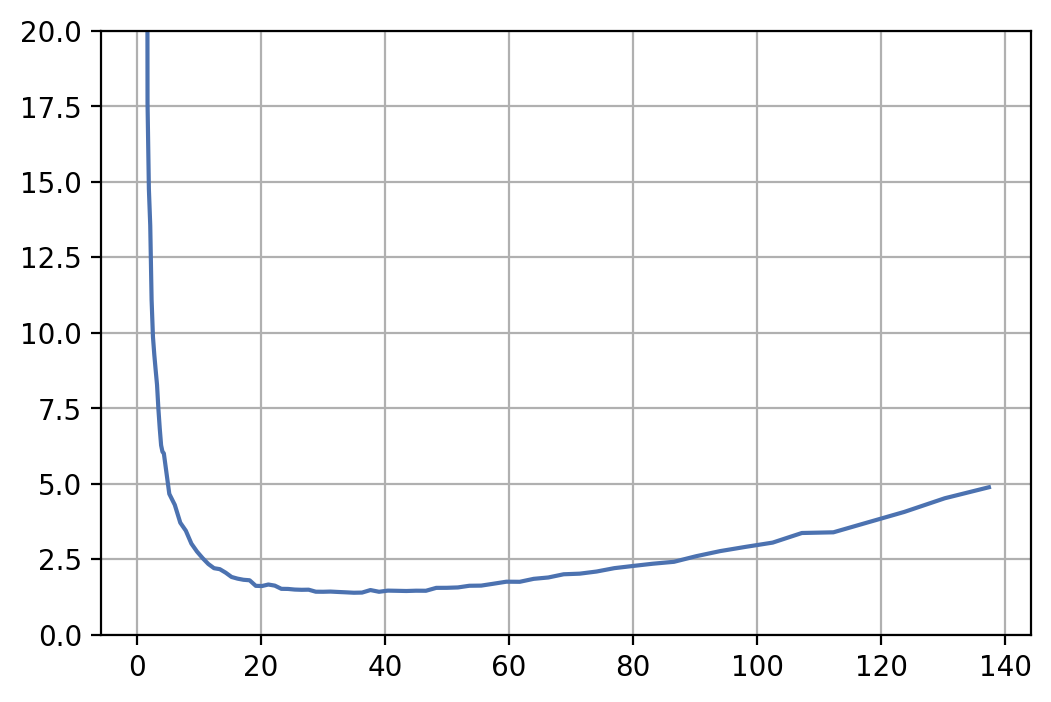

In [44]:
plt.figure(dpi=200)
plt.plot(Y,err)
plt.grid(True)
plt.ylim(0,20)

**Самостоятельно** поэкспериментируйте с числом итераций K. На что влияет его величина?

## 5. Исследуем влияние СКО шума

Для удобства экспериментов было бы неплохо переопределить расчет погрешности позиционирования как отдельную функцию. При этом есть нюанс: мы можем вычислять либо всю поверхность погрешности, либо ее заданное сечение, используя либо ранее написанную функцию compute_position(), либо compute_section(). Как вы, вероятно, помните, в Python функция являетс объектом и может быть передана в другую функцию. Вот простой пример того, как работает эта магия:

In [45]:
def xysum(x,y):
    return x+y

def compute_err(compute, a,b):
    c = compute(a,b)
    return c

compute_err(xysum,34,5)

39

Давайте создадим функцию вычисления погрешностей и будем передавать ей функцию вычисления координат как параметр.

In [46]:
def compute_err(compute_coord, std_az, K):
    
    X,Y = compute_coord(X1,Y1,Al_1,X2,Y2,Al_2)
    err = np.zeros(X.shape)

    for i in range(K):
    
        calc_err = lambda x, x_n, y, y_n: np.sqrt((x - x_n)**2 + (y - y_n)**2)
    
        Az1_n = Al_1 + std_az * np.random.randn(Al_1.shape[0])
        Az2_n = Al_2 + std_az * np.random.randn(Al_2.shape[0])
    
        X_n, Y_n = compute_coord(X1,Y1,Az1_n,X2,Y2,Az2_n)
    
        err += calc_err(X,X_n,Y,Y_n)
    err = err / K 
    return err

In [47]:
err = compute_err(compute_section, 1, 500)

In [48]:
err.shape

(81,)

(0.0, 20.0)

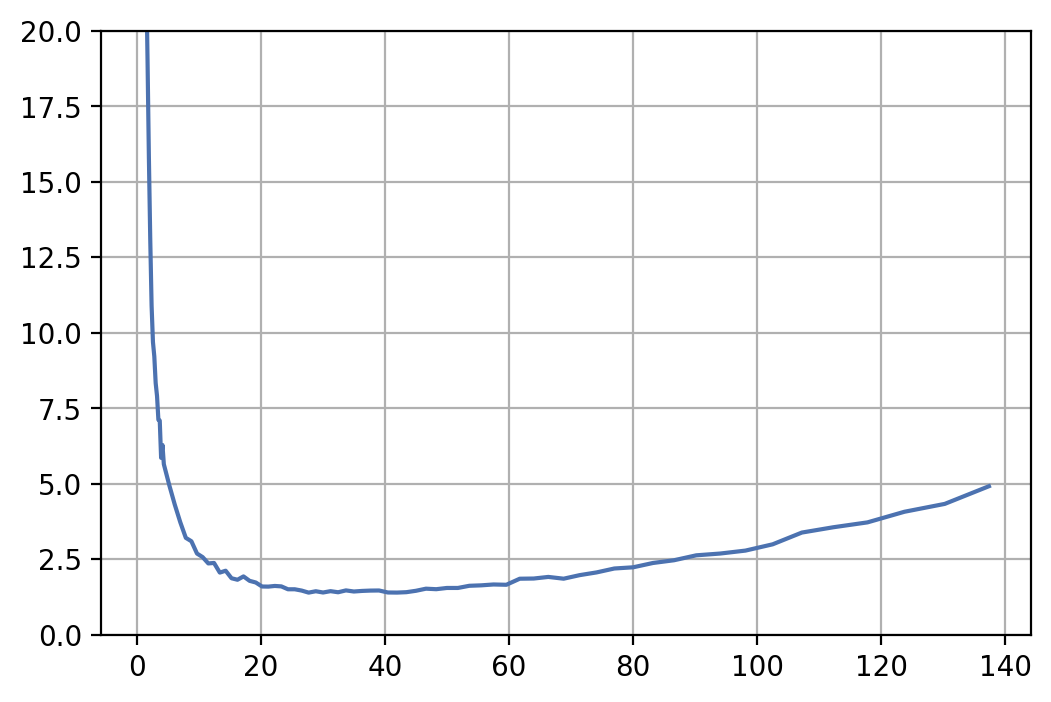

In [49]:
plt.figure(dpi=200)
plt.plot(Y,err)
plt.grid(True)
plt.ylim(0,20)

In [50]:
err = compute_err(compute_position, 1, 500)

In [51]:
err.shape

(81, 81)

(0.0, 20.0)

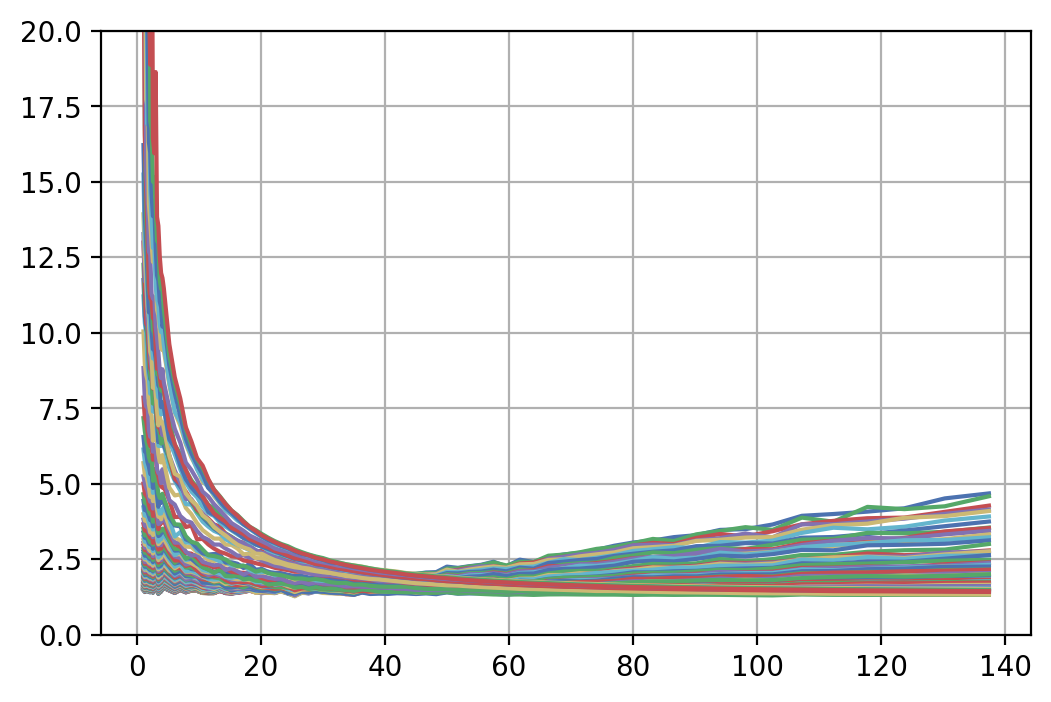

In [52]:
plt.figure(dpi=200)
plt.plot(Y,err)
plt.grid(True)
plt.ylim(0,20)

Смоделируем погрешности при разных СКО шума

In [53]:
sigma = [0.1,0.25, 0.5, 1]
errors = []
for sig in sigma:
    err = compute_err(compute_section, sig, 500)
    errors.append(err)

(0.0, 20.0)

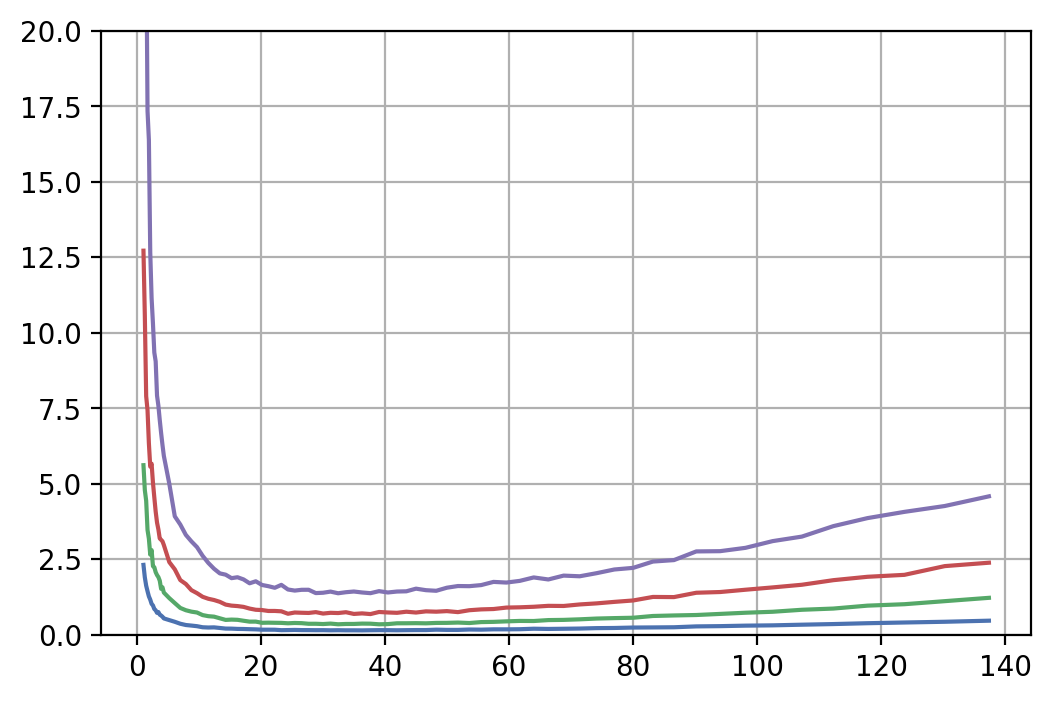

In [54]:
plt.figure(dpi=200)
for err in errors:
    plt.plot(Y,err)
plt.grid(True)
plt.ylim(0,20)

## Выводы